# Bước 1: Import thư viện

In [ ]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

# Bước 2: Đọc dữ liệu

In [ ]:
# đọc dữ liệu từ file csv
df = pd.read_csv('AMZN.csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["Open", "Low",'High','Volume','Adjusted Close'])
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, format='mixed').dt.strftime('%d-%m-%Y')
print(df)

            Date      Close
0     15-05-1997   0.097917
1     16-05-1997   0.086458
2     19-05-1997   0.085417
3     20-05-1997   0.081771
4     21-05-1997   0.071354
...          ...        ...
6433  06-12-2022  88.250000
6434  07-12-2022  88.459999
6435  08-12-2022  90.349998
6436  09-12-2022  89.089996
6437  12-12-2022  88.504997

[6438 rows x 2 columns]


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') # Changed format string
df.sort_values(by=['Date'],inplace=True,ascending=True)
df.set_index('Date', inplace=True)

# Hiển thị lại DataFrame sau khi xóa
print(df)

                Close
Date                 
1997-05-15   0.097917
1997-05-16   0.086458
1997-05-19   0.085417
1997-05-20   0.081771
1997-05-21   0.071354
...               ...
2022-12-06  88.250000
2022-12-07  88.459999
2022-12-08  90.349998
2022-12-09  89.089996
2022-12-12  88.504997

[6438 rows x 1 columns]


# Bước 3: Mô tả dữ liệu

In [ ]:
#dữ liệu 5 dòng đầu
print(df.isnull().sum())

Close    0
dtype: int64


In [ ]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6438 entries, 1997-05-15 to 2022-12-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6438 non-null   float64
dtypes: float64(1)
memory usage: 100.6 KB


In [ ]:
#mô tả bộ dữ liệu
df.describe()

,Close
count,6438.000000
mean,30.830217
std,47.831222
min,0.069792
25%,1.990625
50%,6.282750
75%,37.104250
max,186.570496


# Bước 4: Tiền xử lý dữ liệu

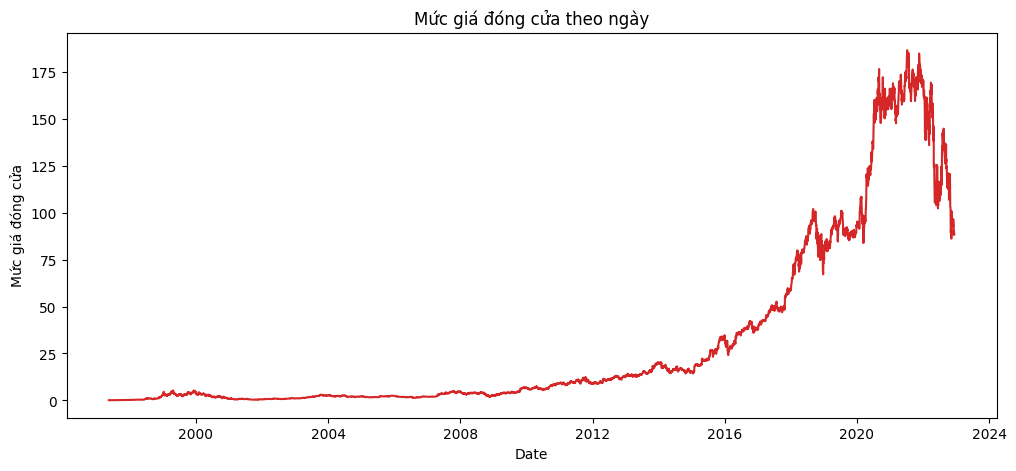

                Close
Date                 
1997-05-15   0.097917
1997-05-16   0.086458
1997-05-19   0.085417
1997-05-20   0.081771
1997-05-21   0.071354
...               ...
2022-12-06  88.250000
2022-12-07  88.459999
2022-12-08  90.349998
2022-12-09  89.089996
2022-12-12  88.504997

[6438 rows x 1 columns]


In [ ]:
def plot_df(Price, y, title="", xlabel='Date', ylabel='Mức giá đóng cửa', dpi=100):
    plt.figure(figsize=(12,5), dpi=dpi)
    plt.plot(y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, y=df, title='Mức giá đóng cửa theo ngày')
print(df)

In [ ]:
#chia tập dữ liệu
data = df.values
train_data = data[:4507]
test_data = data[4507:]

In [ ]:
data

array([[9.79169980e-02],
       [8.64579980e-02],
       [8.54170020e-02],
       ...,
       [9.03499985e+01],
       [8.90899963e+01],
       [8.85049973e+01]])

In [ ]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [ ]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [ ]:
x_train

[array([1.50803699e-04, 8.93615717e-05, 8.37798448e-05, 6.42303153e-05,
        8.37530352e-06, 0.00000000e+00, 2.79248330e-05, 5.02679015e-05,
        3.63054877e-05, 2.93189028e-05, 2.79248330e-05, 3.07183720e-05,
        2.23377173e-05, 5.58172693e-06, 3.90936702e-05, 6.98174310e-05,
        7.81927291e-05, 5.02679015e-05, 3.90936702e-05, 5.58496660e-05,
        5.02679015e-05, 4.74743249e-05, 2.93189028e-05, 3.07183720e-05,
        3.07183720e-05, 3.49060184e-05, 2.79248330e-05, 3.07183720e-05,
        3.07183720e-05, 3.07183720e-05, 2.51312564e-05, 3.90936702e-05,
        3.21124847e-05, 5.16619713e-05, 1.38235398e-04, 1.61972574e-04,
        2.42958842e-04, 2.48545958e-04, 3.12776273e-04, 2.40165308e-04,
        1.98278062e-04, 2.79264367e-04, 2.51339534e-04, 2.20621130e-04,
        2.03865177e-04, 2.10846363e-04, 1.98278062e-04, 2.40165308e-04,
        2.31790005e-04, 2.23409356e-04]),
 array([8.93615717e-05, 8.37798448e-05, 6.42303153e-05, 8.37530352e-06,
        0.00000000e+00

In [ ]:
y_train

[0.00024854595776708426,
 0.00029043320456717504,
 0.00028205790640547547,
 0.00026809548723083845,
 0.0002736772516956196,
 0.0002457524187082558,
 0.00021782759108280203,
 0.00022899642830332995,
 0.00020944693637294615,
 0.0002401653084191385,
 0.0002499400704700606,
 0.00021503401449060307,
 0.00021503401449060307,
 0.00020386517727007515,
 0.00019269094596802041,
 0.0001731414165042661,
 0.0002066533597807473,
 0.0002066533597807473,
 0.00019269094596802041,
 0.00019548452256021927,
 0.00022062113014163038,
 0.00025413307341811157,
 0.00024714649387786174,
 0.00026250837694172116,
 0.00025273360952888905,
 0.00025692126129069385,
 0.0002513395343592832,
 0.00030998269649755883,
 0.00029602032021820235,
 0.00043006810404794705,
 0.0004942984193706206,
 0.0005110543722421759,
 0.0004719606645009137,
 0.0006143837464923579,
 0.00045520471162935827,
 0.0005250167485215323,
 0.0005389845564157859,
 0.0005082607956499771,
 0.0006842011345707782,
 0.0008322112946798794,
 0.00086572328085

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# Bước 5: Xây dựng và huấn luyện mô hình

In [ ]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

In [ ]:
#huấn luyện mô hình
save_model = "save_model.h5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=150,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/150

Epoch 1: loss improved from inf to 0.00550, saving model to save_model.h5
90/90 - 16s - loss: 0.0055 - 16s/epoch - 175ms/step
Epoch 2/150


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 0.00550 to 0.00353, saving model to save_model.h5
90/90 - 12s - loss: 0.0035 - 12s/epoch - 138ms/step
Epoch 3/150

Epoch 3: loss improved from 0.00353 to 0.00328, saving model to save_model.h5
90/90 - 12s - loss: 0.0033 - 12s/epoch - 139ms/step
Epoch 4/150

Epoch 4: loss improved from 0.00328 to 0.00302, saving model to save_model.h5
90/90 - 12s - loss: 0.0030 - 12s/epoch - 138ms/step
Epoch 5/150

Epoch 5: loss did not improve from 0.00302
90/90 - 11s - loss: 0.0031 - 11s/epoch - 118ms/step
Epoch 6/150

Epoch 6: loss did not improve from 0.00302
90/90 - 12s - loss: 0.0032 - 12s/epoch - 135ms/step
Epoch 7/150

Epoch 7: loss improved from 0.00302 to 0.00292, saving model to save_model.h5
90/90 - 12s - loss: 0.0029 - 12s/epoch - 136ms/step
Epoch 8/150

Epoch 8: loss did not improve from 0.00292
90/90 - 12s - loss: 0.0029 - 12s/epoch - 135ms/step
Epoch 9/150

Epoch 9: loss improved from 0.00292 to 0.00277, saving model to save_model.h5
90/90 - 12s - loss: 0.002

In [ ]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("save_model.h5")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

140/140 [==============================] - 6s 33ms/step


# Bước 6: Tái sử dụng mô hình

In [ ]:
#xử lý dữ liệu test
test = df[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[4507:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

61/61 [==============================] - 3s 50ms/step


# Độ chính xác của mô hình

<ipython-input-77-3b5587e4ca5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-77-3b5587e4ca5d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


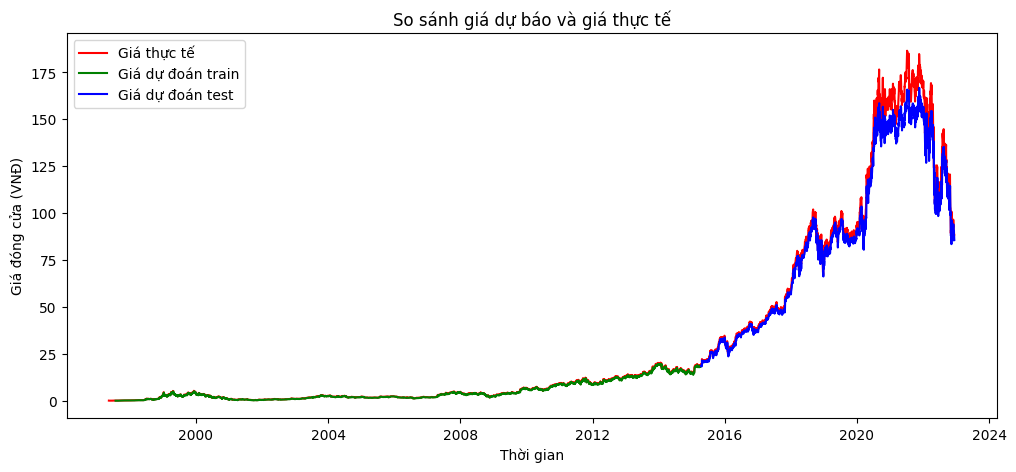

In [ ]:
#lập biểu đồ so sánh
train_data1 = df[50:4507]
test_data1 = df[4507:]

plt.figure(figsize=(12,5))
plt.plot(df,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [ ]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train:',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9970145015299093
Sai số tuyệt đối trung bình trên tập train: 0.20370921317995466
Phần trăm sai số tuyệt đối trung bình tập train: 0.06829966597313117


In [ ]:
train_data1

,Close,Dự đoán
Date,,
1997-07-28,0.116146,0.049121
1997-07-29,0.123958,0.052981
1997-07-30,0.122396,0.059791
1997-07-31,0.119792,0.059068
1997-08-01,0.120833,0.057240
...,...,...
2015-04-08,19.059999,18.193340
2015-04-09,19.177000,18.525883
2015-04-10,19.132500,18.613335


In [ ]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9757878365614301
Sai số tuyệt đối trung bình trên tập test (VNĐ): 5.305837470181268
Phần trăm sai số tuyệt đối trung bình tập test: 0.04714974448724023


In [ ]:
test_data1

,Close,Dự đoán
Date,,
2015-04-15,19.172501,18.713875
2015-04-16,19.302000,18.633015
2015-04-17,18.778000,18.766108
2015-04-20,19.475500,18.273640
2015-04-21,19.559000,18.949772
...,...,...
2022-12-06,88.250000,87.407417
2022-12-07,88.459999,85.460991
2022-12-08,90.349998,86.297676


# Thử dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 [==============================] - 0s 30ms/step


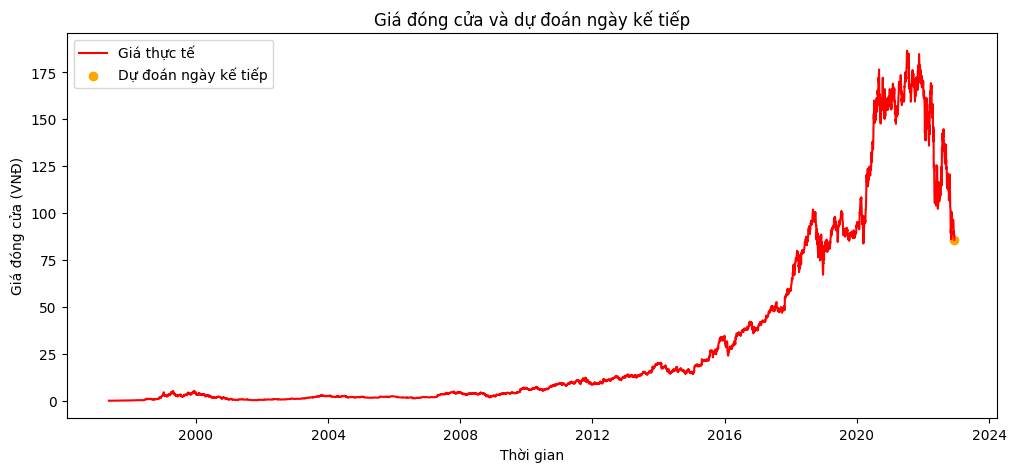

Dự đoán giá đóng cửa cho ngày kế tiếp 85.77543640136719


In [ ]:
next_date = df.index[-1] + pd.Timedelta(days=1)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Close'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Close': [y_next_predict[0][0]]}, index=[next_date])
df = pd.concat([df, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], label='Giá thực tế', color='red')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('Giá đóng cửa và dự đoán ngày kế tiếp')
plt.legend()
plt.show()

# Hiển thị giá dự đoán cho ngày kế tiếp
print(f"Dự đoán giá đóng cửa cho ngày kế tiếp {y_next_predict[0][0]}")
